# Wind farm optimisation

In [1]:
import importlib
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src import functions as fns
from src import optimisation as opt
from src import data as rd

## Power curve [MW] and Weibull wind speed distribution

In [2]:
extent = rd.kish_basin_extent(dat_path=os.path.join("data", "kish-basin"))

In [3]:
# extract data for wind farms at 150 m
weibull = fns.read_weibull_data(
    data_path_weibull=os.path.join(
        "data", "weibull-parameters-wind-speeds", "Weibull_150m_params_ITM.zip"
    ),
    data_path_wind_farms=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

In [4]:
weibull

,Name,"(c, min)","(c, max)","(c, mean)","(k, min)","(k, max)","(k, mean)"
0,Codling Wind Park,10.3,10.8,10.550000,1.9,2.0,1.95
1,Dublin Array,9.9,10.6,10.292857,1.9,2.0,1.95
2,North Irish Sea Array (NISA),10.4,11.1,10.806250,2.1,2.2,2.12


In [4]:
ref_data = {}

In [5]:
# generate Weibull distribution
for n in weibull["Name"]:
    ref_data[n] = {}
    ref_data[n]["wind_speed"] = [0 + 0.01 * n for n in range(3100)]
    ref_data[n]["power_curve"] = []
    ref_data[n][n] = []
    for v in ref_data[n]["wind_speed"]:
        ref_data[n]["power_curve"].append(opt.ref_power_curve(v=v))
        ref_data[n][n].append(
            opt.weibull_probability_distribution(
                v=v,
                k=weibull[weibull["Name"] == n][("k", "mean")].iloc[0],
                c=weibull[weibull["Name"] == n][("c", "mean")].iloc[0],
            )
        )
    ref_data[n] = pd.DataFrame(ref_data[n])

In [6]:
ref_data = pd.concat(ref_data.values(), axis=1).T.drop_duplicates().T

In [8]:
ref_data.head()

,wind_speed,power_curve,Codling Wind Park,Dublin Array,North Irish Sea Array (NISA)
0,0.00,0.0,0.000000,0.000000,0.000000
1,0.01,0.0,0.000248,0.000260,0.000079
2,0.02,0.0,0.000479,0.000503,0.000171
3,0.03,0.0,0.000705,0.000739,0.000269
4,0.04,0.0,0.000926,0.000972,0.000371


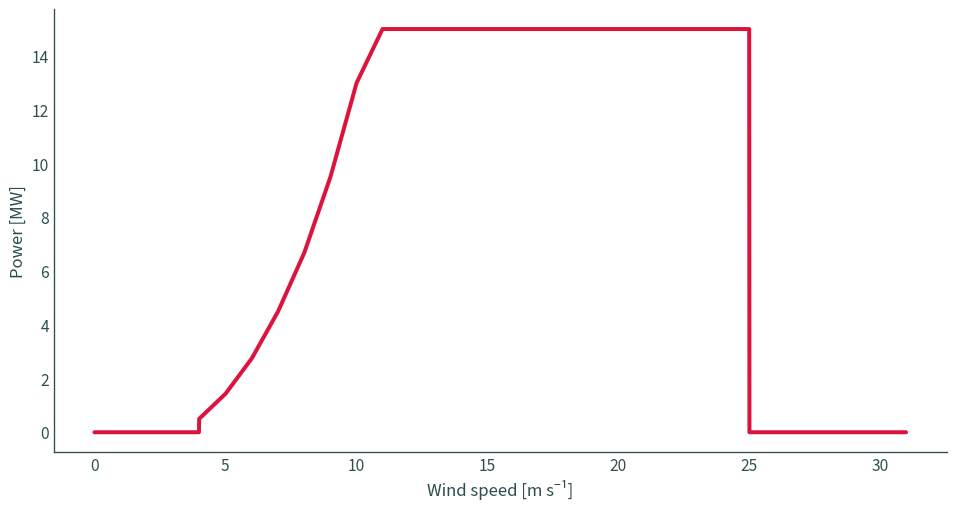

In [9]:
ax = ref_data.plot(
    x="wind_speed",
    y="power_curve",
    ylabel="Power [MW]",
    linewidth=3,
    color="crimson",
    figsize=(12, 6),
    legend=False,
)
ax.set_xlabel("Wind speed [m s\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]")
ax.set_ylabel("Power [MW]")
sns.despine()

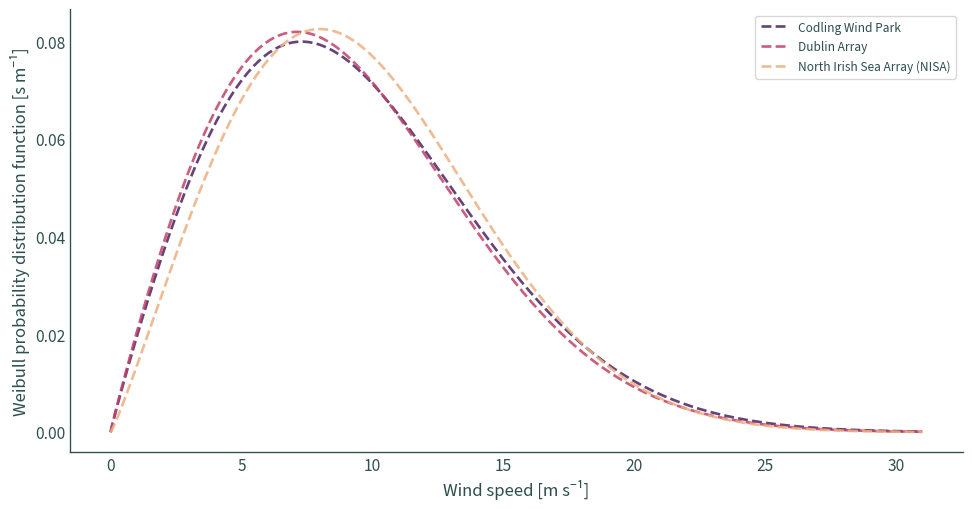

In [10]:
ax = ref_data.drop(columns=["power_curve"]).plot(
    x="wind_speed",
    cmap="flare_r",
    figsize=(12, 6),
    linestyle="dashed",
    linewidth=2,
    alpha=0.85,
)
ax.set_xlabel("Wind speed [m s\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]")
ax.set_ylabel(
    "Weibull probability distribution function "
    "[s m\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]"
)
sns.despine()

## Annual energy production [MWh]

In [7]:
# max wind farm capacity
weibull["capacity"] = [1300, 824, 500]

In [8]:
# number of 15 MW turbines, rounded down to the nearest integer
weibull["n_turbines"] = (weibull["capacity"] / 15).astype(int)

In [9]:
aep = []
integral = []
abserr = []
for n in weibull["Name"]:
    aepwt = opt.annual_energy_production(
        n_turbines=weibull[weibull["Name"] == n]["n_turbines"].iloc[0],
        k=weibull[weibull["Name"] == n][("k", "mean")].iloc[0],
        c=weibull[weibull["Name"] == n][("c", "mean")].iloc[0],
    )
    aep.append(aepwt)

In [10]:
aep = pd.DataFrame(aep)
aep.columns = ["AEP", "integral", "abserr"]

In [11]:
aep = pd.concat([weibull, aep], axis=1)

In [16]:
aep

,Name,"(c, min)","(c, max)","(c, mean)","(k, min)","(k, max)","(k, mean)",capacity,n_turbines,AEP,integral,abserr
0,Codling Wind Park,10.3,10.8,10.550000,1.9,2.0,1.95,1300,86,5.668353e+06,8.360106,4.565276e-07
1,Dublin Array,9.9,10.6,10.292857,1.9,2.0,1.95,824,54,3.471511e+06,8.154141,4.675453e-07
2,North Irish Sea Array (NISA),10.4,11.1,10.806250,2.1,2.2,2.12,500,33,2.291175e+06,8.806387,4.437917e-07


## Annual hydrogen production [kg]

In [12]:
aep["AHP"] = opt.annual_hydrogen_production(aep=aep["AEP"])

In [18]:
aep

,Name,"(c, min)","(c, max)","(c, mean)","(k, min)","(k, max)","(k, mean)",capacity,n_turbines,AEP,integral,abserr,AHP
0,Codling Wind Park,10.3,10.8,10.550000,1.9,2.0,1.95,1300,86,5.668353e+06,8.360106,4.565276e-07,9.985922e+07
1,Dublin Array,9.9,10.6,10.292857,1.9,2.0,1.95,824,54,3.471511e+06,8.154141,4.675453e-07,6.115752e+07
2,North Irish Sea Array (NISA),10.4,11.1,10.806250,2.1,2.2,2.12,500,33,2.291175e+06,8.806387,4.437917e-07,4.036357e+07


## CAPEX for pipeline [€ km⁻¹]

In [13]:
# 1,000 MW electrolyser
capex = opt.capex_pipeline(e_cap=1000)

In [20]:
capex

1414063.9561690202

## LCOH for pipeline [€ kg⁻¹]

In [14]:
aep["LCOH"] = opt.lcot_pipeline(
    capex=capex, transmission_distance=100, ahp=aep["AHP"]
)

In [15]:
aep

,Name,"(c, min)","(c, max)","(c, mean)","(k, min)","(k, max)","(k, mean)",capacity,n_turbines,AEP,integral,abserr,AHP,LCOH
0,Codling Wind Park,10.3,10.8,10.550000,1.9,2.0,1.95,1300,86,5.668353e+06,8.360106,4.565276e-07,9.985922e+07,0.115806
1,Dublin Array,9.9,10.6,10.292857,1.9,2.0,1.95,824,54,3.471511e+06,8.154141,4.675453e-07,6.115752e+07,0.189091
2,North Irish Sea Array (NISA),10.4,11.1,10.806250,2.1,2.2,2.12,500,33,2.291175e+06,8.806387,4.437917e-07,4.036357e+07,0.286504
